# How does the taxonomic distribution of contigs differ by soil layer (mineral vs organic) in Colorado?

This notebook uses the existing NMDC-runtime API endpoints (as of May 2024) to explore how the taxononomic distribution of metagenome contigs differ by the mineral and organic soil layers in Colorado. It involves 9 API requests to reach the scaffold lineage TSV data objects in order to analyze the taxanomic distribution. Iterating through the TSV files includes 100+ API calls to get the necessary taxonomic counts and is time consuming. 

In [1]:
# Load essential libraries
library(jsonlite, warn.conflicts=FALSE)
library(dplyr, warn.conflicts=FALSE)
library(tidyr, warn.conflicts=FALSE)
library(readr, warn.conflicts=FALSE)
library(ggplot2, warn.conflicts=FALSE)

## Define a general API call funtion to nmdc-runtimeThis function provides a general-purpose way to make an API request to NMDC's runtime API. Note that this function will only return the first page of results. The function's input includes the name of the collection to access (e.g. biosample_set), the filter to be performed, the maximum page size, and a list of the fields to be retrieved. It returns the metadata as a dataframe.

In [2]:
get_first_page_results <- function(collection, filter, max_page_size, fields) {
  og_url <- paste0(
      'https://api.microbiomedata.org/nmdcschema/', 
      collection, '?&filter=', filter, '&max_page_size=', max_page_size, '&projection=', fields
      )
  
  response <- jsonlite::fromJSON(URLencode(og_url, repeated = TRUE))
  
  return(response)
}

## Define an nmdc-runtime API call function to include paginationThe get_next_results function uses the get_first_page_results function, defined above, to retrieve the rest of the results from a call with multiple pages. It takes the same inputs as the get_first_page_results function above: the name of the collection to be retrieved, the filter string, the maximum page size, and a list of the fields to be returned. This function returns the results as a single dataframe (can be nested). It uses the next_page_token key in each page of results to retrieve the following page.

In [3]:
get_next_results <- function(collection, filter_text, max_page_size, fields) {
  initial_data <- get_first_page_results(collection, filter_text, max_page_size, fields)
  results_df <- initial_data$resources
  
  if (!is.null(initial_data$next_page_token)) {
    next_page_token <- initial_data$next_page_token
    
    while (TRUE) {
      url <- paste0('https://api.microbiomedata.org/nmdcschema/', collection, '?&filter=', filter_text, '&max_page_size=', max_page_size, '&page_token=', next_page_token, '&projection=', fields)
      response <- jsonlite::fromJSON(URLencode(url, repeated = TRUE))

      results_df <- results_df %>% bind_rows(response$resources)
      next_page_token <- response$next_page_token
      
      if (is.null(next_page_token)) {
        break
      }
    }
  }
  
  return(results_df)
}

# 1. Get all biosamples where soil_horizon exists and the geo_loc_name has "Colorado" in the name

The first step in answering how the taxonomic distribution of contigs differ by soil layer is to get a list of all the biosamples that have metadata for soil_horizon and a string matching "Colorado, Rocky Mountains" for the geo_loc_name. We use the get_next_results function (defined above) to do this. We query the biosample_set collection with a mongo-like filter of {"soil_horizon":{"$exists": true}, "geo_loc_name.has_raw_value": {"$regex": "Colorado"}}, a maximum page size of 100, and specifying that we want three fields returned id, soil_horizon, and geo_loc_name. Note that id is always returned. Since we will be joining the results of multiple API requests with a field of id for different collections, we can change the name of the id key to be more explicit - calling it biosample_id instead.

In [4]:
# Get biosamples using get_next_results function
biosample_df <- get_next_results(
    collectio = 'biosample_set', 
    filter_text = '{"soil_horizon":{"$exists": true}, "geo_loc_name.has_raw_value": {"$regex": "Colorado"}}', 
    max_page_size = 100, 
    fields = 'id,soil_horizon,geo_loc_name'
    )

# Clarify the column names
biosample_df <- biosample_df %>%
    unnest(
        cols = c(
            geo_loc_name
        ), names_sep = "_") %>% 
    rename(biosample_id = id,
           geo_loc_name = geo_loc_name_has_raw_value)
head(biosample_df)

biosample_id,soil_horizon,geo_loc_name
<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range"
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range"
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains"
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range"
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling"
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range"


## Define an API request function that uses a list of ids to filter onThis function constructs a different type of API request that takes a list of ids or similar (e.g. `biosample` ids as retreived above). The `id_field` input is a string of the name of the id field name (e.g. `id` or `has_output`), the name of the new collection to be queried, the name of the field to match the previous ids on in the new collection, and a list of the fields to be returned.

In [5]:
get_results_by_id <- function(collection, match_id_field, id_list, fields, max_id = 50) {
    # collection: the name of the collection to query
    # match_id_field: the field in the new collection to match to the id_list
    # id_list: a list of ids to filter on
    # fields: a list of fields to return
    # max_id: the maximum number of ids to include in a single query
    
    # If id_list is longer than max_id, split it into chunks of max_id
    if (length(id_list) > max_id) {
        id_list <- split(id_list, ceiling(seq_along(id_list)/max_id))
    } else {
        id_list <- list(id_list)
    }
    
    output <- list()
    for (i in 1:length(id_list)) {
        # Cast as a character vector and add double quotes around each ID
        mongo_id_string <- as.character(id_list[[i]]) %>%
            paste0('"', ., '"') %>%
            paste(collapse = ', ')
        
        # Create the filter string
        filter = paste0('{"', match_id_field, '": {"$in": [', mongo_id_string, ']}}')
        
        # Get the data
        output[[i]] = get_next_results(
            collection = collection,
            filter = filter,
            max_page_size = max_id*3, #assumes that there are no more than 3 records per query
            fields = fields
        )
    }
    output_df <- bind_rows(output)
    }

# 2. Get all Pooling results where the Pooling `has_input` are the biosample idsWe use the `get_results_by_id` function above to get a list of all pooling results whose field, `has_input` are the `biosample_id`s we retrieved in step 1. After, the pooling results are unnested to a flat data frame, andthe names are cleaned up so it is clear which collection the results are from. 

In [6]:
pooling_df <- get_results_by_id(
    collection = 'pooling_set',
    match_id_field = 'has_input',
    id_list = biosample_df$biosample_id,
    fields = 'id,has_input,has_output',
    max_id = 20
)

# Unnest the has_input and has_output columns, get unique results, and rename the columns.
pooling_df2 <- pooling_df %>%
    unnest(
        cols = c(
            has_input,
            has_output
        ), names_sep = "_") %>%
    distinct() %>%
    rename(pooling_id = id,
           biosample_id = has_input,
           pooling_has_output = has_output)
head(pooling_df2)

biosample_id,pooling_has_output,pooling_id
<chr>,<chr>,<chr>
nmdc:bsm-11-5228zz06,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94
nmdc:bsm-11-1frj0t76,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94
nmdc:bsm-11-nyxsx333,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94
nmdc:bsm-11-ex491068,nmdc:procsm-11-kngzyt90,nmdc:poolp-11-sj9jpg87
nmdc:bsm-11-1byjjh32,nmdc:procsm-11-kngzyt90,nmdc:poolp-11-sj9jpg87
nmdc:bsm-11-da5wpm57,nmdc:procsm-11-kngzyt90,nmdc:poolp-11-sj9jpg87


Merge the biosample and pooling dataframes together to get a dataframe with biosample and pooling data.

In [7]:
biosample_df2 <- left_join(biosample_df, pooling_df2, by = 'biosample_id')
head(biosample_df2)

biosample_id,soil_horizon,geo_loc_name,pooling_has_output,pooling_id
<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-ytthx235,nmdc:poolp-11-gxv2dy50
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-5s07gt34,nmdc:poolp-11-5e2asm75
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-y8w3sk61,nmdc:poolp-11-pak1ws91
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:procsm-11-258vbz70,nmdc:poolp-11-vfkwpy98
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-mr5hf033,nmdc:poolp-11-ay38nw70


# 3. Get processed samples where the the processed sample `id`s are the `pooling_has_output` fieldWe use the `get_results_by_id` function, again, to get a list of the processed sample results whose field, `pooling_has_output` are the processed sample ids. We will return the results only for the processed sample id field and clean up the names so it is clear that they are the identifiers from the `processed_sample_set`. Finally, the results are converted to a data frame and columns are renamed.

In [8]:
process_set1_df <- get_results_by_id(
    collection = 'processed_sample_set',
    match_id_field = 'id',
    id_list = unique(pooling_df2$pooling_has_output),
    fields = 'id',
    max_id = 20
)

process_set1_df <- process_set1_df %>%
    rename(processed_sample_id = id)
head(process_set1_df)

,processed_sample_id
,<chr>
1,nmdc:procsm-11-258vbz70
2,nmdc:procsm-11-2fxf0e98
3,nmdc:procsm-11-33n4p085
4,nmdc:procsm-11-49bwy122
5,nmdc:procsm-11-5s07gt34
6,nmdc:procsm-11-7bwr9s22


Merge the processed sample data with the biosample and pooling data, where the processed sample id is the same as the pooling_has_output


In [9]:
biosample_df3 <- biosample_df2 %>%
    rename(processed_sample_id = pooling_has_output) %>%
    left_join(process_set1_df, by = join_by(processed_sample_id))
head(biosample_df3)

biosample_id,soil_horizon,geo_loc_name,processed_sample_id,pooling_id
<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-ytthx235,nmdc:poolp-11-gxv2dy50
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-5s07gt34,nmdc:poolp-11-5e2asm75
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-y8w3sk61,nmdc:poolp-11-pak1ws91
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:procsm-11-258vbz70,nmdc:poolp-11-vfkwpy98
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-mr5hf033,nmdc:poolp-11-ay38nw70


# 4. Get extraction results where `processed_sample1` identifier is the `has_input` to the `extraction_set`The `get_id_results` function is used, again (you can see the pattern), but this time to query the `extraction_set` using the `processed_sample1` identifier as the `has_input` for the `extraction_set`. The resulting dataframe is unnested and the names are adjusted to make it clear which set the inputs, outputs, and ids are from.

In [10]:
extraction_df <- get_results_by_id(
    collection = 'extraction_set',
    match_id_field = 'has_input',
    id_list = unique(biosample_df3$processed_sample_id),
    fields = 'id,has_input,has_output',
    max_id = 20
)

extraction_df <- extraction_df %>%
    unnest(
        cols = c(
            has_input,
            has_output
        ), names_sep = "_") %>%
    distinct() %>%
    rename(extraction_id = id,
           processed_sample_id = has_input,
           extraction_has_output = has_output)
head(extraction_df)

processed_sample_id,extraction_has_output,extraction_id
<chr>,<chr>,<chr>
nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42,nmdc:extrp-11-fsv8td81
nmdc:procsm-11-kngzyt90,nmdc:procsm-11-h9s7h174,nmdc:extrp-11-v25scb12
nmdc:procsm-11-mr5hf033,nmdc:procsm-11-7qy2y664,nmdc:extrp-11-gnvf5s35
nmdc:procsm-11-33n4p085,nmdc:procsm-11-6xc6vy98,nmdc:extrp-11-j5qc7973
nmdc:procsm-11-2fxf0e98,nmdc:procsm-11-x763xr38,nmdc:extrp-11-y5ewyv43
nmdc:procsm-11-y8w3sk61,nmdc:procsm-11-q086v208,nmdc:extrp-11-9qd5ke92


Merge the extraction data with the biosample, pooling, and processed sample data

In [11]:
biosample_df4 <- biosample_df3 %>%
    left_join(extraction_df, by = join_by(processed_sample_id))
head(biosample_df4)

biosample_id,soil_horizon,geo_loc_name,processed_sample_id,pooling_id,extraction_has_output,extraction_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-ytthx235,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-5s07gt34,nmdc:poolp-11-5e2asm75,nmdc:procsm-11-edpstj65,nmdc:extrp-11-76s2tz21
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-y8w3sk61,nmdc:poolp-11-pak1ws91,nmdc:procsm-11-q086v208,nmdc:extrp-11-9qd5ke92
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:procsm-11-258vbz70,nmdc:poolp-11-vfkwpy98,nmdc:procsm-11-nrrknt87,nmdc:extrp-11-qg3zf244
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-mr5hf033,nmdc:poolp-11-ay38nw70,nmdc:procsm-11-7qy2y664,nmdc:extrp-11-gnvf5s35


# 5. Get processed sample results from the output of the extraction resultsWe query the `processed_sample_set` again, but this time using the `extract_has_output` ids to query the set. We only need to return the `processed_sample_set` identifiers.

In [12]:
process_set2_df <- get_results_by_id(
    collection = 'processed_sample_set',
    match_id_field = 'id',
    id_list = unique(biosample_df4$extraction_has_output),
    fields = 'id',
    max_id = 20
)

process_set2_df <- process_set2_df %>%
    rename(processed_sample_id2 = id)
head(process_set2_df)

,processed_sample_id2
,<chr>
1,nmdc:procsm-11-1bzpzq15
2,nmdc:procsm-11-1qgqxz62
3,nmdc:procsm-11-6xc6vy98
4,nmdc:procsm-11-7qy2y664
5,nmdc:procsm-11-9txgw141
6,nmdc:procsm-11-cd8pg312


Merge the processed sample data with the biosample, pooling, processed sample, and extraction data

In [13]:
biosample_df5 <- biosample_df4 %>%
    rename(processed_sample_id2 = extraction_has_output) %>%
    left_join(process_set2_df, by = join_by(processed_sample_id2))
head(biosample_df5)

biosample_id,soil_horizon,geo_loc_name,processed_sample_id,pooling_id,processed_sample_id2,extraction_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-ytthx235,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-5s07gt34,nmdc:poolp-11-5e2asm75,nmdc:procsm-11-edpstj65,nmdc:extrp-11-76s2tz21
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-y8w3sk61,nmdc:poolp-11-pak1ws91,nmdc:procsm-11-q086v208,nmdc:extrp-11-9qd5ke92
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:procsm-11-258vbz70,nmdc:poolp-11-vfkwpy98,nmdc:procsm-11-nrrknt87,nmdc:extrp-11-qg3zf244
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-mr5hf033,nmdc:poolp-11-ay38nw70,nmdc:procsm-11-7qy2y664,nmdc:extrp-11-gnvf5s35


# 6. Get the `library_preparation_set`

Using the `processed_sample2` identifiers from the last query as the `has_input` for the the `library_preparation_set`, we get a new batch of results, returning the library preparation identifiers, inputs and outputs. The results is unnested and names are clarified to demonstrate they are from the `library_preparation_set`.

In [14]:
library_prep_df <- get_results_by_id(
    collection = 'library_preparation_set',
    match_id_field = 'has_input',
    id_list = unique(biosample_df5$processed_sample_id2),
    fields = 'id,has_input,has_output',
    max_id = 20
)

library_prep_df <- library_prep_df %>%
    unnest(
        cols = c(
            has_input,
            has_output
        ), names_sep = "_") %>%
    distinct() %>%
    rename(library_preparation_id = id,
           processed_sample_id2 = has_input,
           library_preparation_has_output = has_output)
head(library_prep_df)

processed_sample_id2,library_preparation_has_output,library_preparation_id
<chr>,<chr>,<chr>
nmdc:procsm-11-kwaaah42,nmdc:procsm-11-kfkbxp22,nmdc:libprp-11-k5j44e20
nmdc:procsm-11-7qy2y664,nmdc:procsm-11-wd4s5f38,nmdc:libprp-11-wv6p0032
nmdc:procsm-11-x763xr38,nmdc:procsm-11-9ghwha16,nmdc:libprp-11-gasf6t26
nmdc:procsm-11-h9s7h174,nmdc:procsm-11-4z512838,nmdc:libprp-11-t70f6032
nmdc:procsm-11-6xc6vy98,nmdc:procsm-11-44e5ds31,nmdc:libprp-11-8bzn7n07
nmdc:procsm-11-q086v208,nmdc:procsm-11-jkvhv341,nmdc:libprp-11-24s1rh35


Merge the library preparation data with the biosample, pooling, processed sample, extraction, and processed sample data

In [15]:
biosample_df6 <- biosample_df5 %>%
    left_join(library_prep_df, by = join_by(processed_sample_id2))
head(biosample_df6)

biosample_id,soil_horizon,geo_loc_name,processed_sample_id,pooling_id,processed_sample_id2,extraction_id,library_preparation_has_output,library_preparation_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-ytthx235,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-5s07gt34,nmdc:poolp-11-5e2asm75,nmdc:procsm-11-edpstj65,nmdc:extrp-11-76s2tz21,nmdc:procsm-11-tq69qx97,nmdc:libprp-11-pqjwcw60
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041,nmdc:procsm-11-v7s6qh96,nmdc:libprp-11-4qwse385
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-y8w3sk61,nmdc:poolp-11-pak1ws91,nmdc:procsm-11-q086v208,nmdc:extrp-11-9qd5ke92,nmdc:procsm-11-jkvhv341,nmdc:libprp-11-24s1rh35
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:procsm-11-258vbz70,nmdc:poolp-11-vfkwpy98,nmdc:procsm-11-nrrknt87,nmdc:extrp-11-qg3zf244,nmdc:procsm-11-t397mj03,nmdc:libprp-11-p07zpd31
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-mr5hf033,nmdc:poolp-11-ay38nw70,nmdc:procsm-11-7qy2y664,nmdc:extrp-11-gnvf5s35,nmdc:procsm-11-wd4s5f38,nmdc:libprp-11-wv6p0032


# 7. Get third set of proccessed samples from the library preparation outputFor a third, and last time, we query the `processed_sample_set` identifier field using the `lp_has_output` identifiers. We only return the id field (as `processed_sample3`)

In [16]:
process_set3_df <- get_results_by_id(
    collection = 'processed_sample_set',
    match_id_field = 'id',
    id_list = unique(biosample_df6$library_preparation_has_output),
    fields = 'id',
    max_id = 20
)

process_set3_df <- process_set3_df %>%
    rename(processed_sample_id3 = id)
head(process_set3_df)

,processed_sample_id3
,<chr>
1,nmdc:procsm-11-43n6yz70
2,nmdc:procsm-11-44e5ds31
3,nmdc:procsm-11-4jj6k690
4,nmdc:procsm-11-4z512838
5,nmdc:procsm-11-7cpyc435
6,nmdc:procsm-11-9ghwha16


Merge the processed sample data with the biosample, pooling, processed sample, extraction, processed sample, and library preparation data

In [17]:
biosample_df7 <- biosample_df6 %>%
    rename(processed_sample_id3 = library_preparation_has_output) %>%
    left_join(process_set3_df, by = join_by(processed_sample_id3))
head(biosample_df7)

biosample_id,soil_horizon,geo_loc_name,processed_sample_id,pooling_id,processed_sample_id2,extraction_id,processed_sample_id3,library_preparation_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-ytthx235,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-5s07gt34,nmdc:poolp-11-5e2asm75,nmdc:procsm-11-edpstj65,nmdc:extrp-11-76s2tz21,nmdc:procsm-11-tq69qx97,nmdc:libprp-11-pqjwcw60
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041,nmdc:procsm-11-v7s6qh96,nmdc:libprp-11-4qwse385
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-y8w3sk61,nmdc:poolp-11-pak1ws91,nmdc:procsm-11-q086v208,nmdc:extrp-11-9qd5ke92,nmdc:procsm-11-jkvhv341,nmdc:libprp-11-24s1rh35
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:procsm-11-258vbz70,nmdc:poolp-11-vfkwpy98,nmdc:procsm-11-nrrknt87,nmdc:extrp-11-qg3zf244,nmdc:procsm-11-t397mj03,nmdc:libprp-11-p07zpd31
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-mr5hf033,nmdc:poolp-11-ay38nw70,nmdc:procsm-11-7qy2y664,nmdc:extrp-11-gnvf5s35,nmdc:procsm-11-wd4s5f38,nmdc:libprp-11-wv6p0032


# 8. Get omics_processing results from the processed sample identifiers

Using the third batch of processed sample identifiers, we query the `omics_processing_set` on the `has_input` field. The `id` and `has_input` field names are changed to specify that they came from the `omics_processing_set`.

In [18]:
omics_processing_df <- get_results_by_id(
    collection = 'omics_processing_set',
    match_id_field = 'has_input',
    id_list = unique(biosample_df7$processed_sample_id3),
    fields = 'id,has_input',
    max_id = 20
)

omics_processing_df <- omics_processing_df %>%
    unnest(
        cols = c(
            has_input
        ), names_sep = "_") %>%
    rename(omics_processing_id = id,
           processed_sample_id3 = has_input)
head(omics_processing_df)

processed_sample_id3,omics_processing_id
<chr>,<chr>
nmdc:procsm-11-43n6yz70,nmdc:omprc-11-g1n61y55
nmdc:procsm-11-4jj6k690,nmdc:omprc-11-yt96hb84
nmdc:procsm-11-4z512838,nmdc:omprc-11-afejca38
nmdc:procsm-11-7cpyc435,nmdc:omprc-11-by9r5p41
nmdc:procsm-11-9ghwha16,nmdc:omprc-11-bd1eyb41
nmdc:procsm-11-bxg58286,nmdc:omprc-11-t2fdcy08


Merge the omics processing data with the biosample, pooling, processed sample, extraction, processed sample, library preparation, and processed sample data

In [19]:
biosample_df8 <- biosample_df7 %>%
    left_join(omics_processing_df, by = join_by(processed_sample_id3))
head(biosample_df8)

biosample_id,soil_horizon,geo_loc_name,processed_sample_id,pooling_id,processed_sample_id2,extraction_id,processed_sample_id3,library_preparation_id,omics_processing_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-ytthx235,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-5s07gt34,nmdc:poolp-11-5e2asm75,nmdc:procsm-11-edpstj65,nmdc:extrp-11-76s2tz21,nmdc:procsm-11-tq69qx97,nmdc:libprp-11-pqjwcw60,nmdc:omprc-11-769ab655
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041,nmdc:procsm-11-v7s6qh96,nmdc:libprp-11-4qwse385,nmdc:omprc-11-597mc608
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-y8w3sk61,nmdc:poolp-11-pak1ws91,nmdc:procsm-11-q086v208,nmdc:extrp-11-9qd5ke92,nmdc:procsm-11-jkvhv341,nmdc:libprp-11-24s1rh35,NA
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:procsm-11-258vbz70,nmdc:poolp-11-vfkwpy98,nmdc:procsm-11-nrrknt87,nmdc:extrp-11-qg3zf244,nmdc:procsm-11-t397mj03,nmdc:libprp-11-p07zpd31,NA
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-mr5hf033,nmdc:poolp-11-ay38nw70,nmdc:procsm-11-7qy2y664,nmdc:extrp-11-gnvf5s35,nmdc:procsm-11-wd4s5f38,nmdc:libprp-11-wv6p0032,NA


# 9. Get the metagenome_annotation_activity_set using the omics processing identifiers

The `metagenome_annotation_activity_set` is queried using the identifiers obtained from the omics processing to match with the `was_informed_by` field in the `metagenome_annotation_activity_set`. Field names are clarified, once again to specify the collection they came from.

In [20]:
metagenome_annotation_df <- get_results_by_id(
    collection = 'metagenome_annotation_activity_set',
    match_id_field = 'was_informed_by',
    id_list = unique(biosample_df8$omics_processing_id),
    fields = 'id,was_informed_by,has_output',
    max_id = 20
)

metagenome_annotation_df <- metagenome_annotation_df %>%
    unnest(
        cols = c(
            was_informed_by,
            has_output
        ), names_sep = "_") %>%
    rename(metagenome_annotation_id = id,
           omics_processing_id = was_informed_by,
           matagenome_annotation_has_output = has_output)
head(metagenome_annotation_df)

metagenome_annotation_id,omics_processing_id,matagenome_annotation_has_output
<chr>,<chr>,<chr>
nmdc:wfmgan-11-vkf49q20.1,nmdc:omprc-11-htac6662,nmdc:dobj-11-h6cf2s80
nmdc:wfmgan-11-vkf49q20.1,nmdc:omprc-11-htac6662,nmdc:dobj-11-tsy6tn27
nmdc:wfmgan-11-vkf49q20.1,nmdc:omprc-11-htac6662,nmdc:dobj-11-qcxq5096
nmdc:wfmgan-11-vkf49q20.1,nmdc:omprc-11-htac6662,nmdc:dobj-11-57r3zc31
nmdc:wfmgan-11-vkf49q20.1,nmdc:omprc-11-htac6662,nmdc:dobj-11-k4222s45
nmdc:wfmgan-11-vkf49q20.1,nmdc:omprc-11-htac6662,nmdc:dobj-11-erxjvf31


Merge the metagenome annotation data with the biosample, pooling, processed sample, extraction, processed sample, library preparation, processed sample, omics processing, and processed sample data

In [21]:
biosample_df9 <- biosample_df8 %>%
    left_join(metagenome_annotation_df, by = join_by(omics_processing_id), relationship = "many-to-many")
head(biosample_df9)

biosample_id,soil_horizon,geo_loc_name,processed_sample_id,pooling_id,processed_sample_id2,extraction_id,processed_sample_id3,library_preparation_id,omics_processing_id,metagenome_annotation_id,matagenome_annotation_has_output
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-ytthx235,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04,NA,NA
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-5s07gt34,nmdc:poolp-11-5e2asm75,nmdc:procsm-11-edpstj65,nmdc:extrp-11-76s2tz21,nmdc:procsm-11-tq69qx97,nmdc:libprp-11-pqjwcw60,nmdc:omprc-11-769ab655,NA,NA
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041,nmdc:procsm-11-v7s6qh96,nmdc:libprp-11-4qwse385,nmdc:omprc-11-597mc608,nmdc:wfmgan-11-3s20yk38.1,nmdc:dobj-11-b96vap67
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041,nmdc:procsm-11-v7s6qh96,nmdc:libprp-11-4qwse385,nmdc:omprc-11-597mc608,nmdc:wfmgan-11-3s20yk38.1,nmdc:dobj-11-hkqqdt25
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041,nmdc:procsm-11-v7s6qh96,nmdc:libprp-11-4qwse385,nmdc:omprc-11-597mc608,nmdc:wfmgan-11-3s20yk38.1,nmdc:dobj-11-mn4z5956
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041,nmdc:procsm-11-v7s6qh96,nmdc:libprp-11-4qwse385,nmdc:omprc-11-597mc608,nmdc:wfmgan-11-3s20yk38.1,nmdc:dobj-11-jfypfh90


# 10. Get data objects from the metagenome activity result outputsWe query the `data_object_set` using the `matagenome_annotation_has_output` identifiers to match the `id` field in the data objects. We then filter the results for only those results with a `data_object_type` of `Scaffold Lineage tsv` (since this has contig taxonomy results). Note that the `url` is a new field returned that contains the tsvs we will need for the final analysis.

In [22]:
data_object_df <- get_results_by_id(
    collection = 'data_object_set',
    match_id_field = 'id',
    id_list = unique(biosample_df9$matagenome_annotation_has_output),
    fields = 'id,data_object_type,url',
    max_id = 50
)

# Filter the data object results to only include the Scaffold Lineage tsv files
data_object_df <- data_object_df %>%
    rename(data_object_id = id) %>%
    filter(data_object_type == 'Scaffold Lineage tsv')
head(data_object_df)

,data_object_id,data_object_type,url
,<chr>,<chr>,<chr>
1,nmdc:dobj-11-jp45gr33,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-597mc608/nmdc:wfmgan-11-3s20yk38.1/nmdc_wfmgan-11-3s20yk38.1_scaffold_lineage.tsv
2,nmdc:dobj-11-mmv19z03,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-597mc608/nmdc:wfmgan-11-3s20yk38.2/nmdc_wfmgan-11-3s20yk38.2_scaffold_lineage.tsv
3,nmdc:dobj-11-8ybd1f87,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-t2fdcy08/nmdc:wfmgan-11-2a0ap078.1/nmdc_wfmgan-11-2a0ap078.1_scaffold_lineage.tsv
4,nmdc:dobj-11-wn5g7j41,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-yt96hb84/nmdc:wfmgan-11-hv3nyk36.1/nmdc_wfmgan-11-hv3nyk36.1_scaffold_lineage.tsv
5,nmdc:dobj-11-xt9amn82,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-gaptm502/nmdc:wfmgan-11-me7h8h69.1/nmdc_wfmgan-11-me7h8h69.1_scaffold_lineage.tsv
6,nmdc:dobj-11-b6yhf780,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-r5w9js52/nmdc:wfmgan-11-k5a19412.1/nmdc_wfmgan-11-k5a19412.1_scaffold_lineage.tsv


Merge the data object data with the biosample, pooling, processed sample, extraction, processed sample, library preparation, processed sample, omics processing, processed sample, and metagenome annotation data

In [23]:
biosample_df10 <- biosample_df9 %>%
    rename(data_object_id = matagenome_annotation_has_output) %>%
    left_join(data_object_df, by = join_by(data_object_id))
head(biosample_df10)

biosample_id,soil_horizon,geo_loc_name,processed_sample_id,pooling_id,processed_sample_id2,extraction_id,processed_sample_id3,library_preparation_id,omics_processing_id,metagenome_annotation_id,data_object_id,data_object_type,url
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-ytthx235,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04,NA,NA,NA,NA
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:procsm-11-5s07gt34,nmdc:poolp-11-5e2asm75,nmdc:procsm-11-edpstj65,nmdc:extrp-11-76s2tz21,nmdc:procsm-11-tq69qx97,nmdc:libprp-11-pqjwcw60,nmdc:omprc-11-769ab655,NA,NA,NA,NA
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041,nmdc:procsm-11-v7s6qh96,nmdc:libprp-11-4qwse385,nmdc:omprc-11-597mc608,nmdc:wfmgan-11-3s20yk38.1,nmdc:dobj-11-b96vap67,NA,NA
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041,nmdc:procsm-11-v7s6qh96,nmdc:libprp-11-4qwse385,nmdc:omprc-11-597mc608,nmdc:wfmgan-11-3s20yk38.1,nmdc:dobj-11-hkqqdt25,NA,NA
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041,nmdc:procsm-11-v7s6qh96,nmdc:libprp-11-4qwse385,nmdc:omprc-11-597mc608,nmdc:wfmgan-11-3s20yk38.1,nmdc:dobj-11-mn4z5956,NA,NA
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:procsm-11-ez7edj21,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041,nmdc:procsm-11-v7s6qh96,nmdc:libprp-11-4qwse385,nmdc:omprc-11-597mc608,nmdc:wfmgan-11-3s20yk38.1,nmdc:dobj-11-jfypfh90,NA,NA


## Clean up the combined results

In the final step of retrieving and cleaning the data, we clean up the final merged data frame by removing all of the "joining columns" that are not needed in our final analysis. Because some of the biosamples were pooled, we only retain unique url results (and drop the `biosample_id` column). The only columns we retain are the `soil_horizon`, `geo_loc_name`, and the `url` to the tsv. The `final_df` is displayed.

In [24]:
biosample_df_final <- biosample_df10 %>%
    select(biosample_id, soil_horizon, geo_loc_name, data_object_id, data_object_type, url) %>%
    distinct() %>%
    filter(!is.na(url))
head(biosample_df_final)

biosample_id,soil_horizon,geo_loc_name,data_object_id,data_object_type,url
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:dobj-11-jp45gr33,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-597mc608/nmdc:wfmgan-11-3s20yk38.1/nmdc_wfmgan-11-3s20yk38.1_scaffold_lineage.tsv
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:dobj-11-mmv19z03,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-597mc608/nmdc:wfmgan-11-3s20yk38.2/nmdc_wfmgan-11-3s20yk38.2_scaffold_lineage.tsv
nmdc:bsm-11-0gmd9f09,M horizon,"USA: Colorado, Niwot Ridge",nmdc:dobj-11-xt9amn82,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-gaptm502/nmdc:wfmgan-11-me7h8h69.1/nmdc_wfmgan-11-me7h8h69.1_scaffold_lineage.tsv
nmdc:bsm-11-0hz4rd27,O horizon,"USA: Colorado, Niwot Ridge",nmdc:dobj-11-8ybd1f87,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-t2fdcy08/nmdc:wfmgan-11-2a0ap078.1/nmdc_wfmgan-11-2a0ap078.1_scaffold_lineage.tsv
nmdc:bsm-11-0qa78w81,M horizon,"USA: Colorado, North Sterling",nmdc:dobj-11-wn5g7j41,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-yt96hb84/nmdc:wfmgan-11-hv3nyk36.1/nmdc_wfmgan-11-hv3nyk36.1_scaffold_lineage.tsv
nmdc:bsm-11-0yw1rj05,M horizon,"USA: Colorado, North Sterling",nmdc:dobj-11-b6yhf780,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-r5w9js52/nmdc:wfmgan-11-k5a19412.1/nmdc_wfmgan-11-k5a19412.1_scaffold_lineage.tsv


## Show how many results have M horizon vs. O horizon

The `soil_horizon` column can be counted using the `count()` functionality. There are many more samples with associated Scaffold Lineage tsvs from a M horizon biosample than a O horizon.

In [25]:
biosample_df_final %>%
    count(soil_horizon)

soil_horizon,n
<chr>,<int>
M horizon,266
O horizon,58


## Example of what the TSV contig taxa file looks like

A snippet of the TSV file we need to iterate over to get the taxa abundance for the contigs is shown below. The third column is the initial count for the taxa, where each row is `1.0`. However, there are duplicate rows of taxa, meaning there are actually more than `1.0` for several taxa (though they appear as duplicate rows with `1.0` as the count`). We will take this into consideration when we calculate the relative abundance for each taxa.

In [26]:
url <- biosample_df_final$url[1]

# Read the TSV file
contig_taxa_df <- read_tsv(url, col_names = FALSE, show_col_types = FALSE)

# Add column names 
colnames(contig_taxa_df) <- c('contig_id', 'taxa', 'initial_count')

# Show the first few rows
head(contig_taxa_df)

contig_id,taxa,initial_count
<chr>,<chr>,<dbl>
nmdc:wfmgas-11-qdbye406.1_scf_10000_c1,Bacteria;Pseudomonadota;Alphaproteobacteria;Hyphomicrobiales;Nitrobacteraceae;Bradyrhizobium;Bradyrhizobium sp. KBS0725;Bradyrhizobium sp. KBS0725,1
nmdc:wfmgas-11-qdbye406.1_scf_10001_c1,Bacteria;Pseudomonadota;Alphaproteobacteria;Hyphomicrobiales;Propylenellaceae;Propylenella;Propylenella binzhouense;Propylenella binzhouense L72,1
nmdc:wfmgas-11-qdbye406.1_scf_10002_c1,Bacteria;Pseudomonadota;Alphaproteobacteria;Hyphomicrobiales;Nitrobacteraceae;Tardiphaga;Tardiphaga robiniae;Tardiphaga robiniae 1155,1
nmdc:wfmgas-11-qdbye406.1_scf_10003_c1,Bacteria;Pseudomonadota;Alphaproteobacteria;Hyphomicrobiales;Nitrobacteraceae;Bradyrhizobium;Bradyrhizobium lablabi;Bradyrhizobium lablabi GAS165,1
nmdc:wfmgas-11-qdbye406.1_scf_10004_c1,Bacteria;Pseudomonadota;Alphaproteobacteria;Hyphomicrobiales;Nitrobacteraceae;Bradyrhizobium;Bradyrhizobium sp. SRL28;Bradyrhizobium sp. SRL28,1
nmdc:wfmgas-11-qdbye406.1_scf_10005_c1,Bacteria;Pseudomonadota;Alphaproteobacteria;Hyphomicrobiales;Nitrobacteraceae;Bradyrhizobium;Bradyrhizobium sp. AUGA SZCCT0283;Bradyrhizobium sp. AUGA SZCCT0283,1


## Iterate throught the TSVs to get the contig taxa information

Using the readr's `read_tsv` function, the TSV urls can be iterated over gathering the taxa information. The TSVs are converted into dataframes where they are manipulated to suit the data structure needed. The columns are given names and the taxa column is split into a proper list (instead of a string of items separated by a semicolon ;). The third element from the list of taxa is retrieved to get only the phylum level information of the taxa (or unknown to the highest available taxon). A grouping function is performed on the `taxa` column and the `count()` functionality is used to calculate the count for how many times each taxa occurs, which is then used to calculate the relative abundance of each taxa for each sample. 

Any errors in requesting the TSV urls are collected as a dictionary, so we can either try to query them again, or look into why they were not able to be collected. 

In [27]:
urls <- unique(biosample_df_final$url)
results_list <- c()
error_dict <- list()

for (i in 1:length(urls)) {
    # if i a factor of 100, print the progress
    if (i %% 10 == 0) {
        print(paste('Processing', i, 'of', length(urls)))
    }
    url <- urls[i]
    tryCatch({
        contig_taxa_df <- read_tsv(url, col_names = FALSE, show_col_types = FALSE)
        colnames(contig_taxa_df) <- c('contig_id', 'taxa', 'initial_count')
        
        # Clean up the taxa column and deal with unknown taxa
        contig_taxa_df$taxa_new <- contig_taxa_df$taxa
        contig_taxa_df$taxa_new <- sapply(strsplit(contig_taxa_df$taxa_new, ';'), function(x) x[3])
        contig_taxa_df$taxa_new <- ifelse(
            is.na(contig_taxa_df$taxa_new), 
            paste('Unknown', sapply(strsplit(contig_taxa_df$taxa, ';'), function(x) x[2])), 
            contig_taxa_df$taxa_new)
        contig_taxa_df$taxa_new <- ifelse(
            contig_taxa_df$taxa_new == "Unknown NA", 
            paste('Unknown', sapply(strsplit(contig_taxa_df$taxa, ';'), function(x) x[1])), 
            contig_taxa_df$taxa_new)
        contig_taxa_df$taxa <- contig_taxa_df$taxa_new

        contig_taxa_df <- contig_taxa_df %>%
            group_by(taxa) %>%
            summarise(count = n()) %>%
            mutate(relative_abundance = count / sum(count))

        # Add the queried url to the dataframe for later joining
        contig_taxa_df$url <- url
        results_list[[i]] <- contig_taxa_df

    }, error = function(e) {
        error_dict[[i]] <- e
    })
}

# Combine results into single dataframe
contig_df <- bind_rows(results_list) 

head(contig_df)

[1] "Processing 10 of 114"
[1] "Processing 20 of 114"
[1] "Processing 30 of 114"
[1] "Processing 40 of 114"
[1] "Processing 50 of 114"
[1] "Processing 60 of 114"
[1] "Processing 70 of 114"
[1] "Processing 80 of 114"
[1] "Processing 90 of 114"
[1] "Processing 100 of 114"
[1] "Processing 110 of 114"


taxa,count,relative_abundance,url
<chr>,<int>,<dbl>,<chr>
Acidimicrobiia,372,7.050796e-03,https://data.microbiomedata.org/data/nmdc:omprc-11-597mc608/nmdc:wfmgan-11-3s20yk38.1/nmdc_wfmgan-11-3s20yk38.1_scaffold_lineage.tsv
Acidithiobacillia,5,9.476876e-05,https://data.microbiomedata.org/data/nmdc:omprc-11-597mc608/nmdc:wfmgan-11-3s20yk38.1/nmdc_wfmgan-11-3s20yk38.1_scaffold_lineage.tsv
Actinomycetes,18409,3.489196e-01,https://data.microbiomedata.org/data/nmdc:omprc-11-597mc608/nmdc:wfmgan-11-3s20yk38.1/nmdc_wfmgan-11-3s20yk38.1_scaffold_lineage.tsv
Agaricomycetes,151,2.862017e-03,https://data.microbiomedata.org/data/nmdc:omprc-11-597mc608/nmdc:wfmgan-11-3s20yk38.1/nmdc_wfmgan-11-3s20yk38.1_scaffold_lineage.tsv
Alphaproteobacteria,18355,3.478961e-01,https://data.microbiomedata.org/data/nmdc:omprc-11-597mc608/nmdc:wfmgan-11-3s20yk38.1/nmdc_wfmgan-11-3s20yk38.1_scaffold_lineage.tsv
Anaerolineae,17,3.222138e-04,https://data.microbiomedata.org/data/nmdc:omprc-11-597mc608/nmdc:wfmgan-11-3s20yk38.1/nmdc_wfmgan-11-3s20yk38.1_scaffold_lineage.tsv


## Clean up the relative abundance data to fill in NAs with 0 for unobserved taxa

In [28]:
# First merge to get the url for geo_loc_name and soil_horizon
biosample_taxa_df <- biosample_df_final %>%
    select(soil_horizon, geo_loc_name, url) %>%
    distinct() %>%
    right_join(contig_df, by = join_by(url))

# Then pivot the table to fill in the relative abundance as zero for un-observed taxa
biosample_taxa_df_wide <- biosample_taxa_df %>%
    pivot_wider(id_cols = c(url, soil_horizon, geo_loc_name),
        names_from = taxa, values_from = relative_abundance) %>%
    replace(is.na(.), 0)

# And unpivot the table to get the taxa relative abundance for each biosample
biosample_taxa_df <- biosample_taxa_df_wide %>%
    pivot_longer(cols = -c(url, soil_horizon, geo_loc_name), names_to = 'taxa', values_to = 'relative_abundance')

## Plot the average taxa abundance for all M and O horizon soil samplesFirst calculate the average relative abundance for each taxa in each soil horizon.  Next, we'll pull out the top ten taxa and lump all others into an "Other" category for plotting purposes using the `forcats::fct_other` function.  Then we'll calculate the mean relative abundance of each taxa for each soil horizon. Finally, we'll choose an appropriate color palette for the plot, and plot the relative abundance of each taxa for each soil horizon at each location.

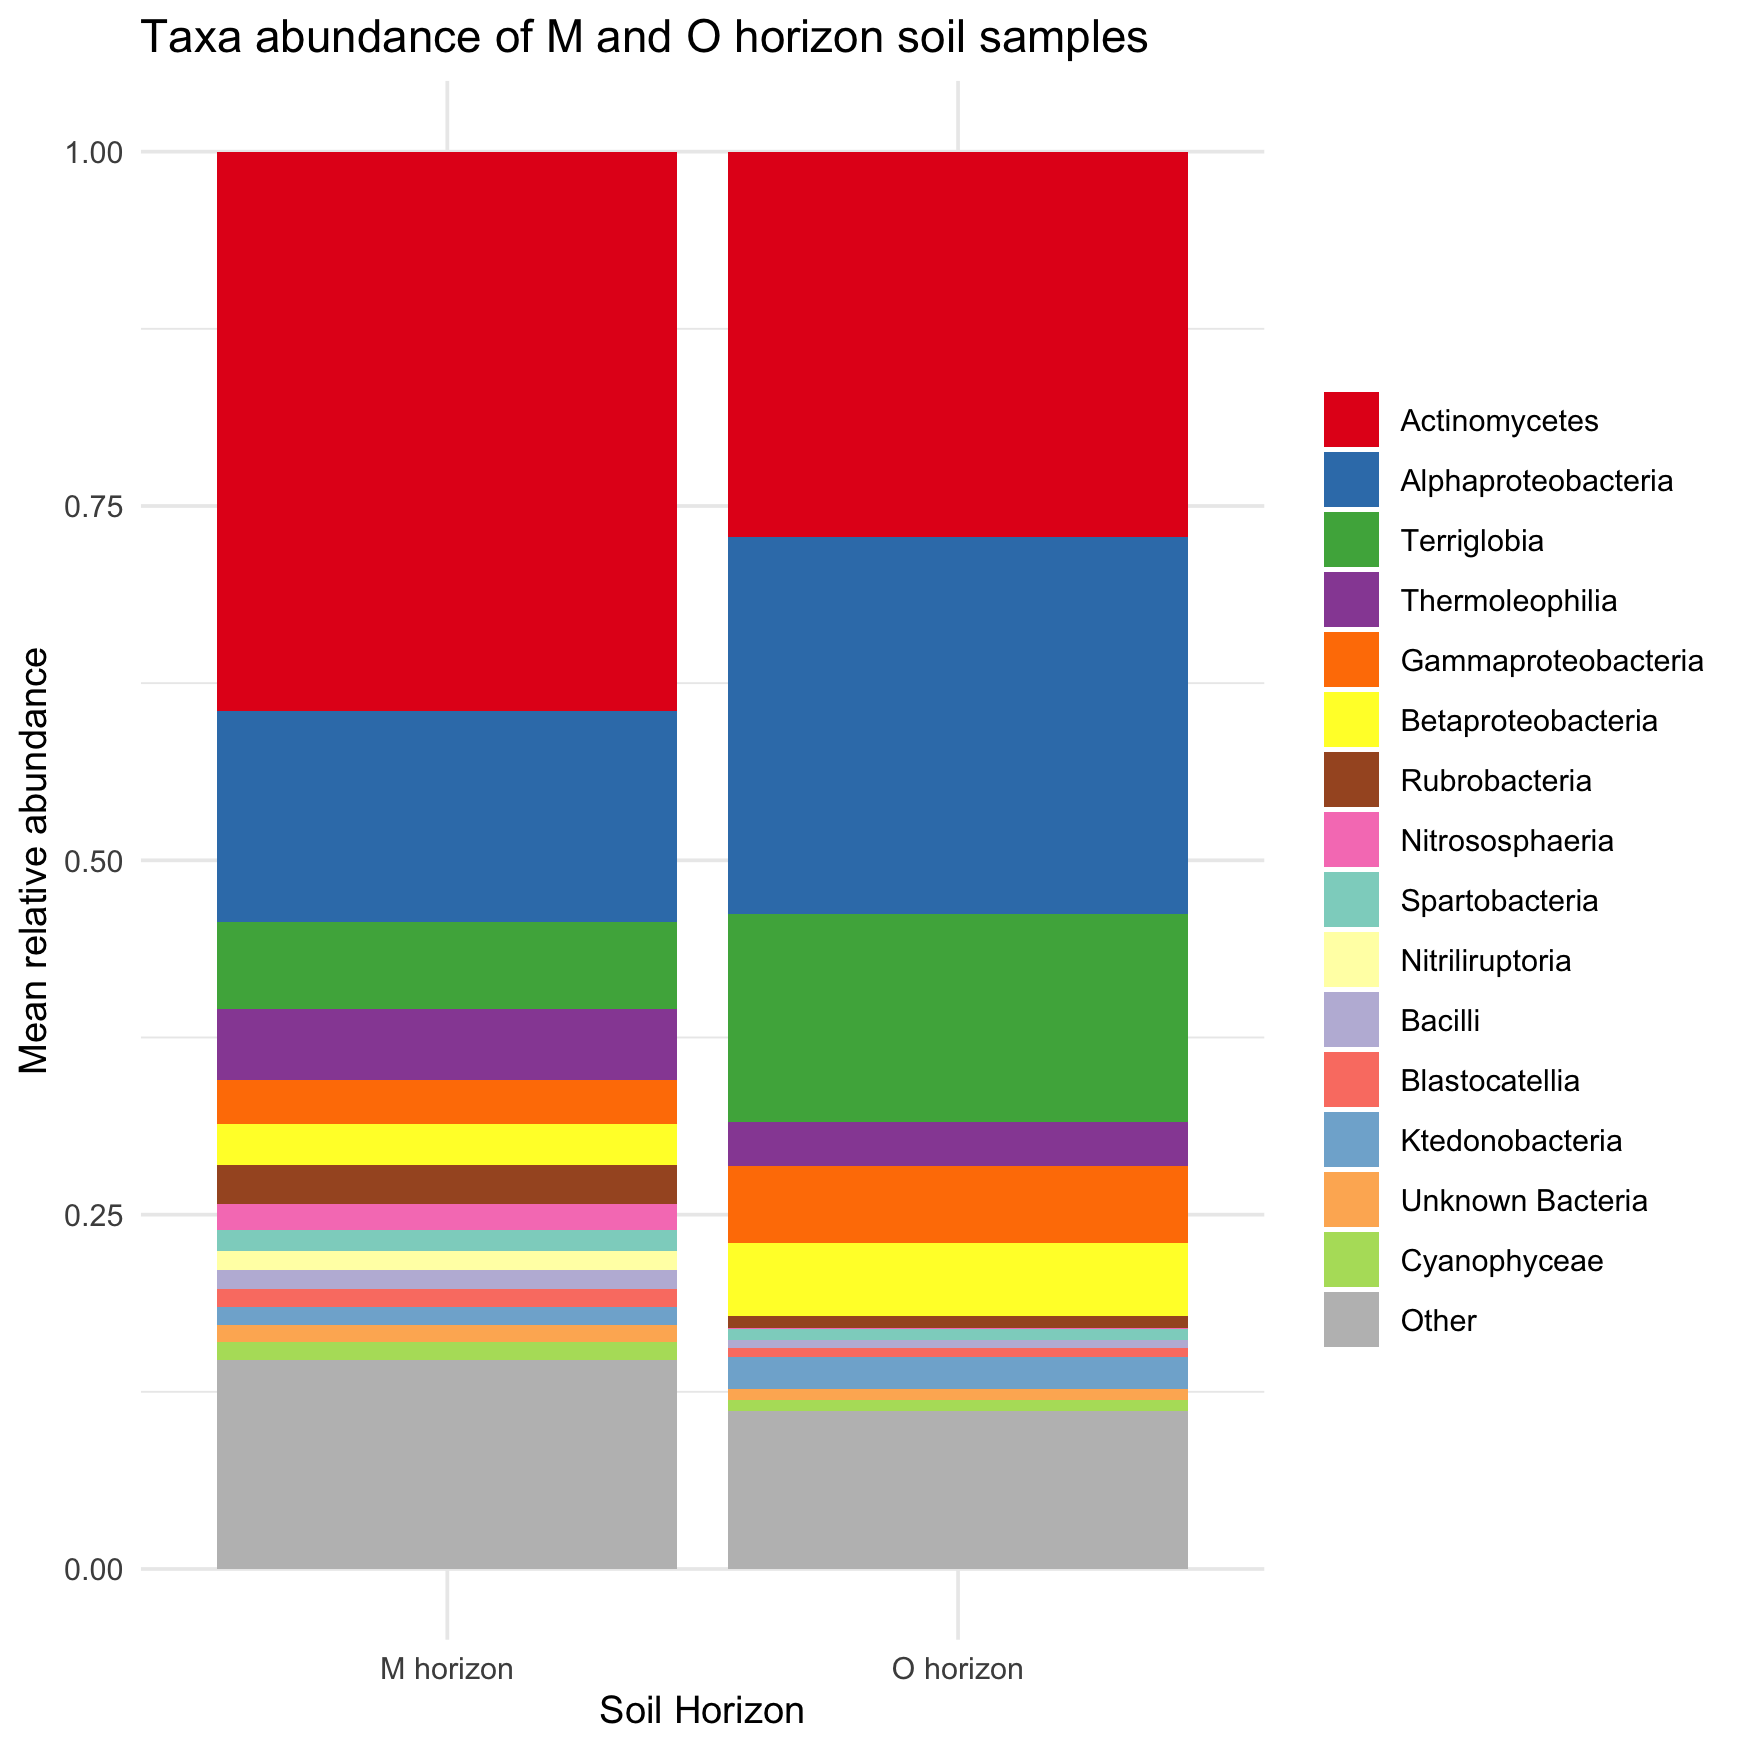

In [34]:
options(dplyr.summarise.inform = FALSE)
horizon_taxa <- biosample_taxa_df %>%
    group_by(soil_horizon, taxa) %>%
    summarise(mean_relative_abundance = mean(relative_abundance))%>%
    arrange(mean_relative_abundance) %>%
    mutate(taxa = factor(taxa, levels = rev(unique(taxa)))) %>%
    mutate(taxa_lump = forcats::fct_other(taxa, keep = levels(taxa)[1:15], other_level = 'Other')) 
           
# Make color palette that is 9 colors long, and followed with grey
color_pal <- c(RColorBrewer::brewer.pal(8, 'Set1'), RColorBrewer::brewer.pal(7, 'Set3'), 'grey')
g <- ggplot(horizon_taxa, aes(x = soil_horizon, y = mean_relative_abundance, fill = taxa_lump)) +
    geom_bar(stat = 'identity', color = NA) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = 'Taxa abundance of M and O horizon soil samples',
         x = 'Soil Horizon', y = 'Mean relative abundance', fill = NULL) +
    scale_fill_manual(values = color_pal) +
    theme_minimal() 
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 250)
g

## Plot the taxa abundance of M and O horizon soil samples for each location
First we'll pull out the top ten taxa and lump all others into an "Other" category for plotting purposes using the `forcats::fct_other` function.  Then we'll calculate the mean relative abundance of each taxa for each soil horizon for each location. Finally, we'll plot the relative abundance of each taxa for each soil horizon at each location (using the same color palette as above).

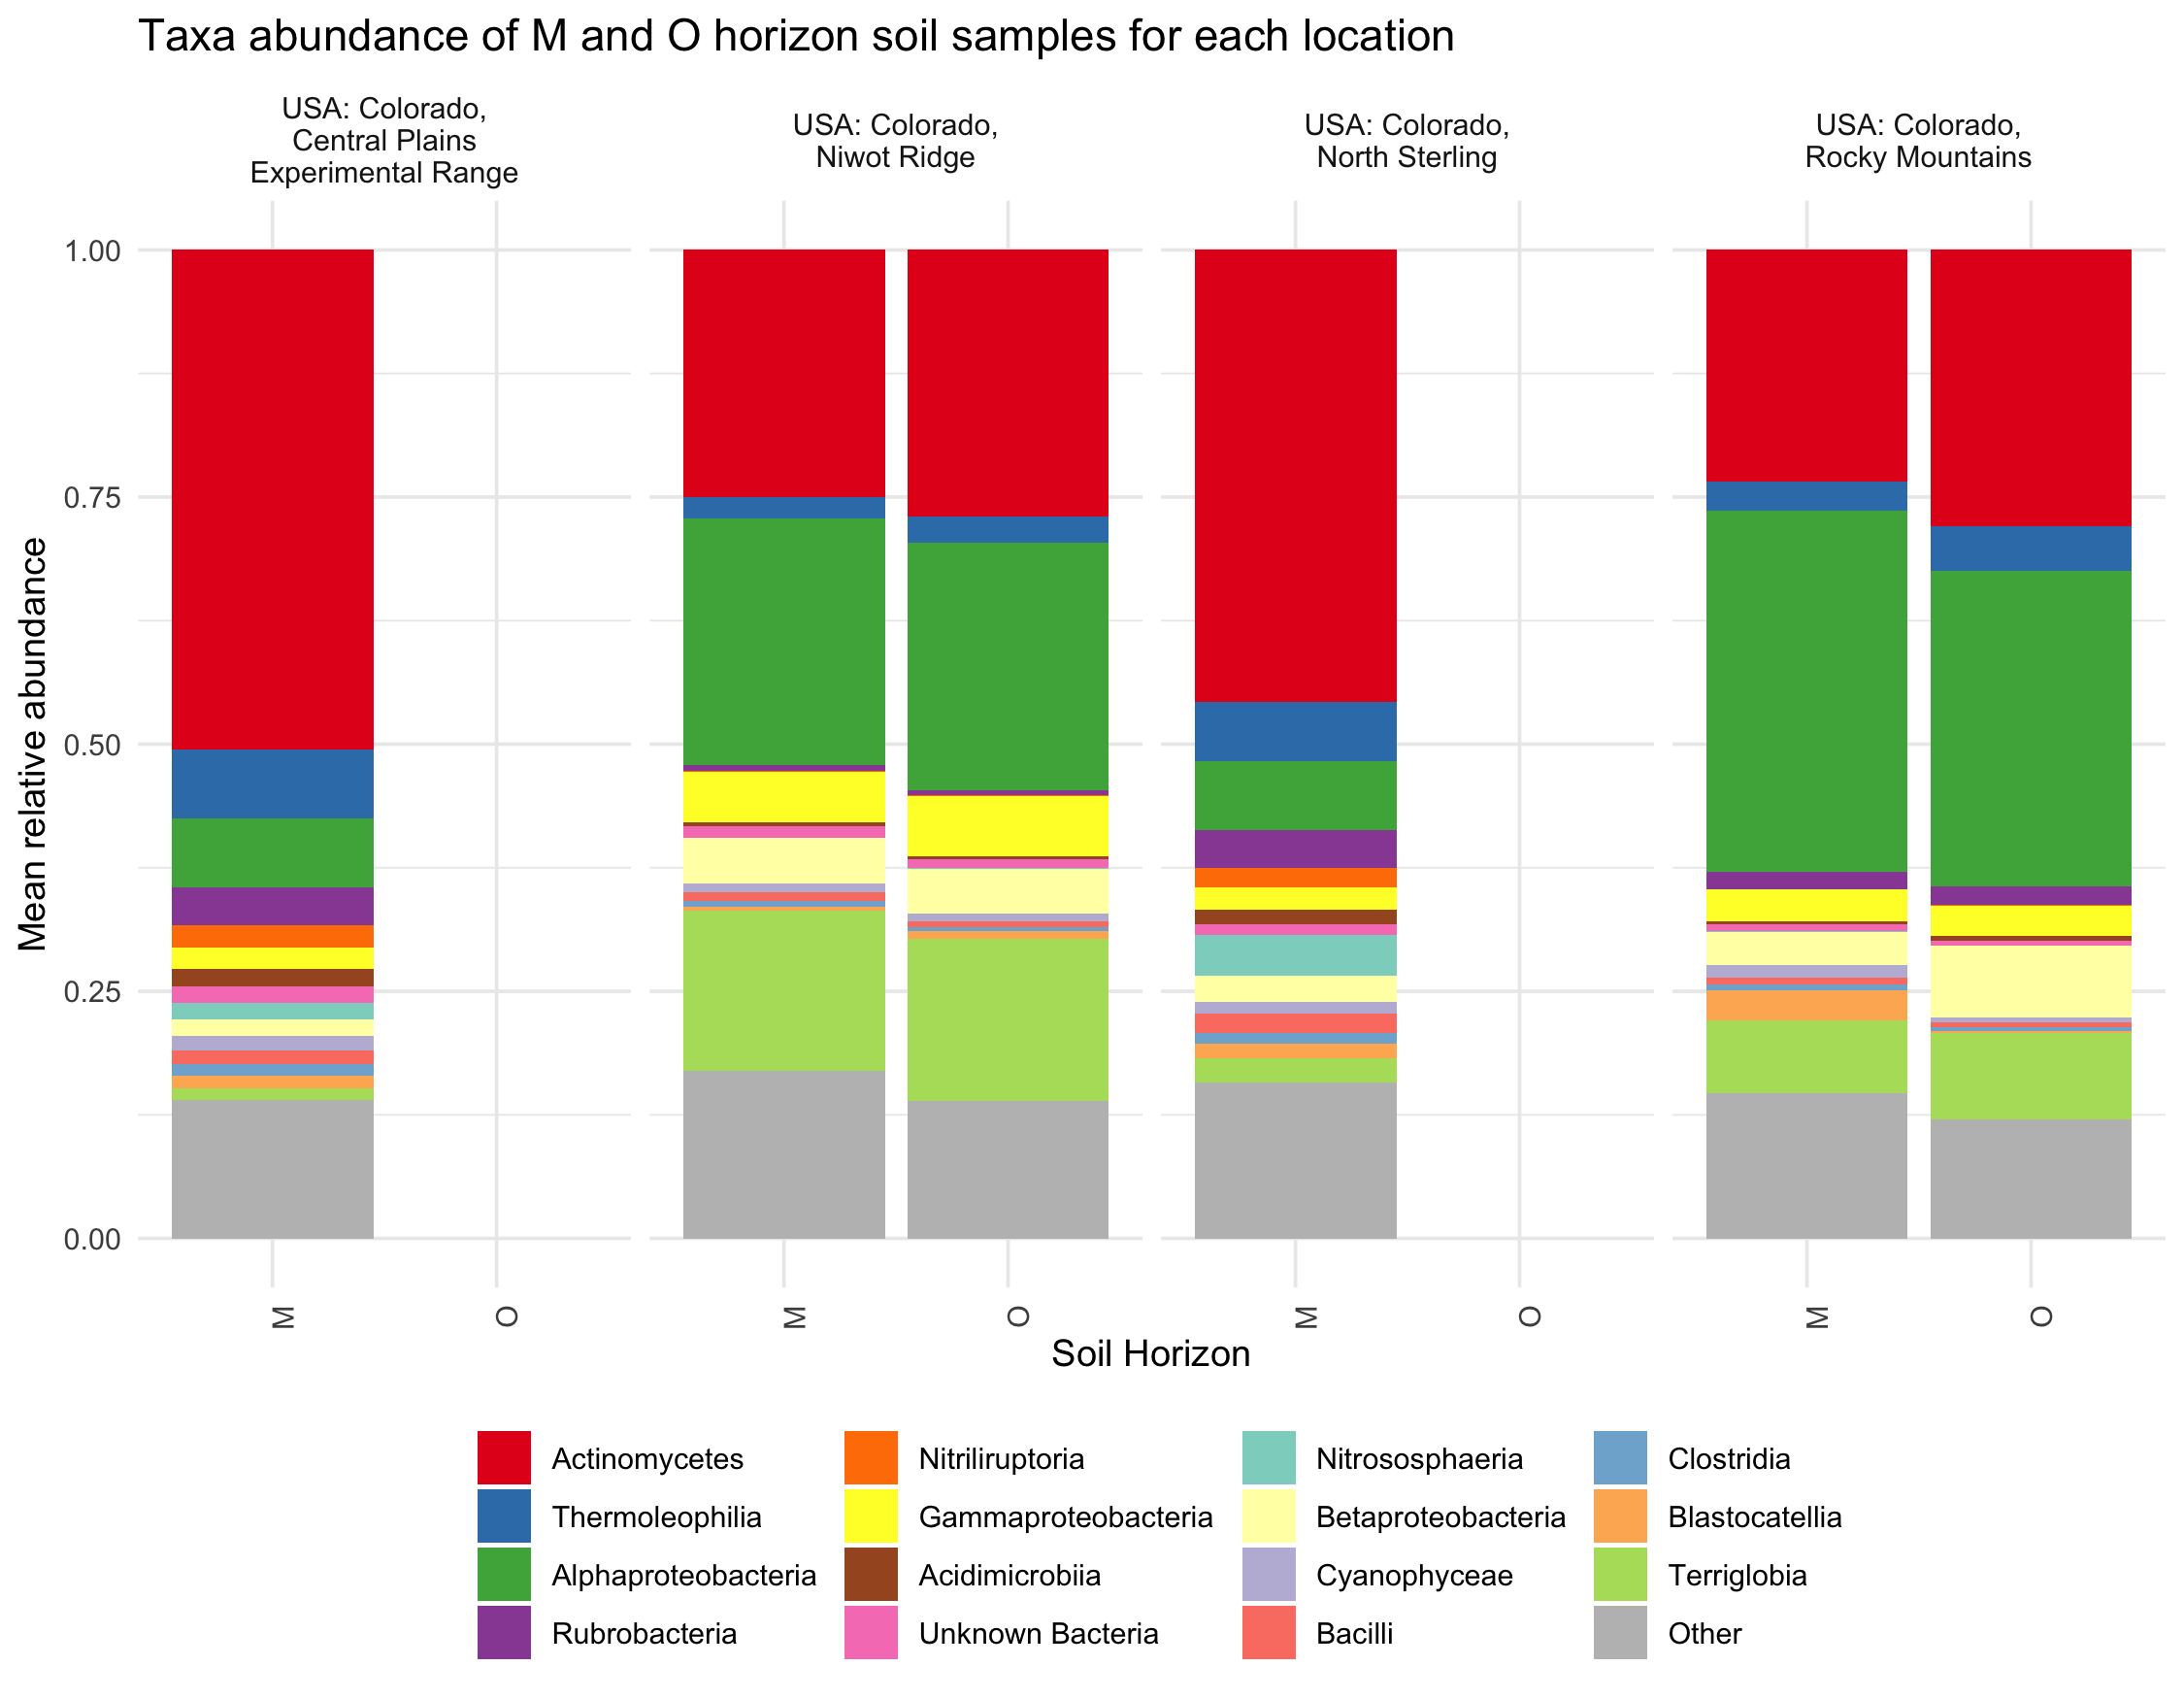

In [33]:
geo_taxa <- biosample_taxa_df %>%
    group_by(geo_loc_name, soil_horizon, taxa) %>%
    summarise(mean_relative_abundance = mean(relative_abundance)) %>%
    arrange(mean_relative_abundance) %>%
    mutate(taxa = factor(taxa, levels = rev(unique(taxa)))) %>%
    mutate(taxa_lump = forcats::fct_other(taxa, keep = levels(taxa)[1:15], other_level = 'Other')) %>%
    mutate(soil_horizon = factor(soil_horizon, levels = c('M horizon', 'O horizon'), labels = c('M', 'O')))

g <- ggplot(geo_taxa, aes(x = soil_horizon, y = mean_relative_abundance, fill = taxa_lump)) +
    geom_bar(stat = 'identity', color = NA) +
    facet_wrap(~geo_loc_name, nrow = 1,labeller =  label_wrap_gen(width = 20, multi_line = TRUE)) +
    labs(title = 'Taxa abundance of M and O horizon soil samples for each location',
         x = 'Soil Horizon', y = 'Mean relative abundance', fill = NULL) +
    scale_fill_manual(values = color_pal) +
    theme_minimal()+
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
          legend.position = "bottom") 
options(repr.plot.width = 9, repr.plot.height = 7, repr.plot.res = 250)
g